In [2]:
pip install pyts

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.8/2.5 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0609 - mae: 0.1903 - val_loss: 0.0356 - val_mae: 0.1725
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0192 - mae: 0.1076 - val_loss: 0.0350 - val_mae: 0.1712
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0154 - mae: 0.0988 - val_loss: 0.0429 - val_mae: 0.1941
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0137 - mae: 0.0946 - val_loss: 0.0247 - val_mae: 0.1399
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0133 - mae: 0.0911 - val_loss: 0.0229 - val_mae: 0.1336
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0125 - mae: 0.0900 - val_loss: 0.0228 - val_mae: 0.1337
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110 - mae: 0.0847 - val_loss: 0.0177 - val_mae: 0.1143
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120 - mae: 0.0860 - val_loss: 0.0139 - val_mae: 0.0983
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.011

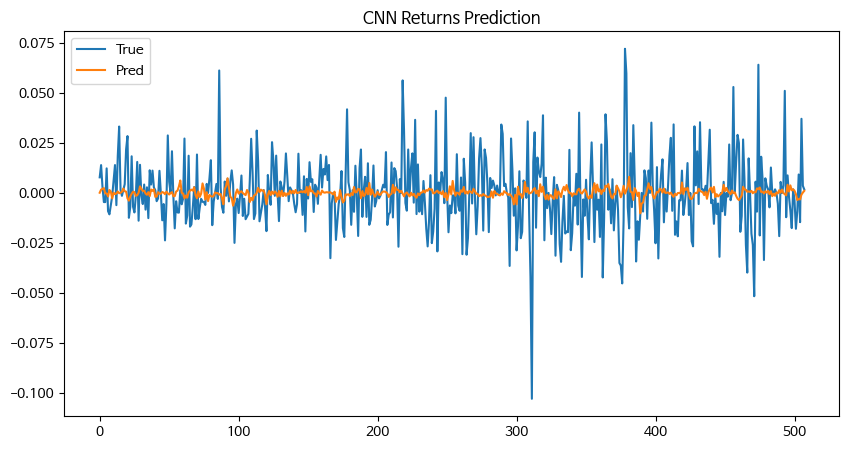

In [10]:
import numpy as np
import pandas as pd
import sys
import time
from pykrx import stock
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 설정
ticker = '005930'        # 삼성전자의 KRX 티커 코드
start_date = '20150101'    # YYYYMMDD 형식
end_date = '20250601'
window_size = 20           # GAF 변환에 사용할 창 크기
image_size = window_size   # image_size를 window_size로 설정 (<= window_size)


def download_data_pykrx(ticker, start, end):
    """PyKrX를 이용해 KRX 주가(OHLCV) 데이터를 가져옵니다."""
    try:
        df = stock.get_market_ohlcv_by_date(start, end, ticker)
        if df.empty:
            raise ValueError("PyKrX: 반환된 데이터프레임이 비어 있습니다.")
        # 컬럼명을 pandas 스타일로 변환
        df.rename(columns={
            "시가": "Open", "고가": "High", "저가": "Low",
            "종가": "Adj Close", "거래량": "Volume"
        }, inplace=True)
        return df
    except Exception as e:
        print(f"PyKrX 데이터 다운로드 실패: {e}", file=sys.stderr)
        sys.exit(1)

# 1. 데이터 불러오기 및 수익률 계산
df = download_data_pykrx(ticker, start_date, end_date)
df['Return'] = df['Adj Close'].pct_change().fillna(0)
returns = df['Return'].values

# 충분한 데이터 확인
if len(returns) <= window_size + 1:
    print(f"데이터가 부족합니다. window_size({window_size}) 이상 필요", file=sys.stderr)
    sys.exit(1)

# 2. 슬라이딩 윈도우로 이미지 생성
def create_rolling_images(returns, window_size=20, image_size=20):
    # image_size는 window_size 이하여야 함
    gaf = GramianAngularField(image_size=image_size, method='summation')
    X, y = [], []
    for i in range(window_size, len(returns) - 1):
        window = returns[i-window_size:i].reshape(1, -1)
        img = gaf.fit_transform(window)[0]
        X.append(img)
        y.append(returns[i+1])
    X = np.array(X).reshape(-1, image_size, image_size, 1)
    return X, np.array(y)

X, y = create_rolling_images(returns, window_size, image_size)

# 3. 데이터 정규화 및 분할
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)

# 4. CNN 모델 정의
def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)), Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)), Dropout(0.25),
        Flatten(), Dense(128, activation='relu'), Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 5. 학습 및 평가
def train_and_evaluate():
    model = build_cnn((image_size, image_size, 1))
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[es]
    )
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Test MSE: {loss:.6f}, MAE: {mae:.6f}")
    y_pred = scaler.inverse_transform(model.predict(X_test))
    y_true = scaler.inverse_transform(y_test.reshape(-1,1))
    plt.figure(figsize=(10,5))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Pred')
    plt.legend()
    plt.title('CNN Returns Prediction')
    plt.show()

if __name__ == '__main__':
    train_and_evaluate()


## 2025년6월30일까지 가격 예측

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0813 - mae: 0.2022 - val_loss: 0.0525 - val_mae: 0.2132
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0180 - mae: 0.1065 - val_loss: 0.0570 - val_mae: 0.2235
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0171 - mae: 0.1038 - val_loss: 0.0409 - val_mae: 0.1834
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0132 - mae: 0.0912 - val_loss: 0.0318 - val_mae: 0.1583
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120 - mae: 0.0867 - val_loss: 0.0301 - val_mae: 0.1538
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0124 - mae: 0.0861 - val_loss: 0.0178 - val_mae: 0.1101
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0096 - mae: 0.0777 - val_loss: 0.0115 - val_mae: 0.0825
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0099 - mae: 0.0779 - val_loss: 0.0129 - val_mae: 0.0896
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.008

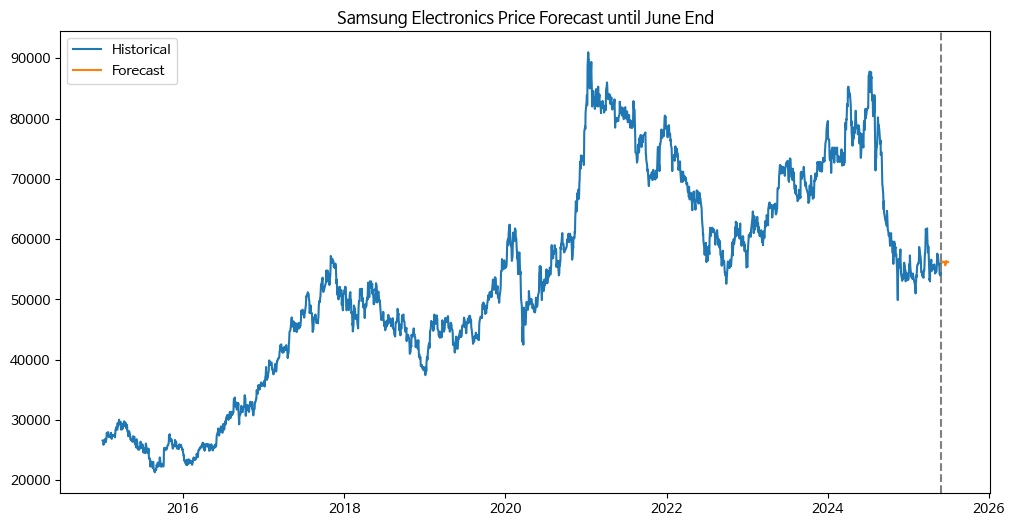

In [11]:
import numpy as np
import pandas as pd
import sys
from pykrx import stock
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 설정
ticker = '005930'                 # 삼성전자의 KRX 티커 코드
start_date = '20150101'             # YYYYMMDD 형식
end_date = '20250601'               # 데이터 수집 종료
window_size = 20                    # GAF 변환에 사용할 창 크기
image_size = window_size            # image_size는 window_size 이하
forecast_end = '20250630'           # 예측 종료 날짜 (YYYYMMDD)


def download_data_pykrx(ticker, start, end):
    """PyKrX를 이용해 KRX 주가(OHLCV) 데이터를 가져옵니다."""
    df = stock.get_market_ohlcv_by_date(start, end, ticker)
    if df.empty:
        print(f"PyKrX 데이터 없음: {ticker} {start}-{end}", file=sys.stderr)
        sys.exit(1)
    df.rename(columns={"종가": "Adj Close"}, inplace=True)
    return df

# 1. 데이터 로드 및 수익률 계산
df = download_data_pykrx(ticker, start_date, end_date)
df['Return'] = df['Adj Close'].pct_change().fillna(0)
returns = df['Return'].values
close_prices = df['Adj Close'].values

# 2. 과거 이미지 생성 함수 정의
def create_image(window):
    gaf = GramianAngularField(image_size=image_size, method='summation')
    img = gaf.fit_transform(window.reshape(1, -1))[0]
    return img.reshape(image_size, image_size, 1)

# 3. 데이터셋 준비
def prepare_dataset(returns):
    X, y = [], []
    for i in range(window_size, len(returns) - 1):
        X.append(create_image(returns[i-window_size:i]))
        y.append(returns[i+1])
    return np.array(X), np.array(y)

X, y = prepare_dataset(returns)
# 정규화
scaler = MinMaxScaler(feature_range=(0,1))
y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()

# 학습용: 모든 과거 데이터 사용
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)

# 4. CNN 모델 정의 및 학습
def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)), Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)), Dropout(0.25),
        Flatten(), Dense(128, activation='relu'), Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_cnn((image_size, image_size, 1))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[es])

# 5. 미래 예측
from datetime import datetime, timedelta
# 예측할 날짜 리스트 생성
last_date = pd.to_datetime(df.index[-1])
end_date_forecast = pd.to_datetime(forecast_end, format='%Y%m%d')
forecast_days = (end_date_forecast - last_date).days

future_returns = []
window = returns[-window_size:].copy()
for _ in range(forecast_days):
    img = create_image(window)
    r_scaled = model.predict(img.reshape(1, image_size, image_size,1))[0,0]
    r = scaler.inverse_transform([[r_scaled]])[0,0]
    future_returns.append(r)
    # 슬라이딩
    window = np.roll(window, -1)
    window[-1] = r

# 미래 종가 계산
last_price = close_prices[-1]
future_prices = [last_price * (1 + r) for r in future_returns]
future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

# 6. 시각화 및 결과 출력
plt.figure(figsize=(12,6))
plt.plot(df.index, close_prices, label='Historical')
plt.plot(future_dates, future_prices, label='Forecast')
plt.axvline(df.index[-1], linestyle='--', color='gray')
plt.legend()
plt.title('Samsung Electronics Price Forecast until June End')
plt.show()


Epoch 1/50


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1022 - mae: 0.2350 - val_loss: 0.0567 - val_mae: 0.2223
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0181 - mae: 0.1075 - val_loss: 0.0428 - val_mae: 0.1891
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0163 - mae: 0.1015 - val_loss: 0.0428 - val_mae: 0.1889
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0137 - mae: 0.0911 - val_loss: 0.0344 - val_mae: 0.1666
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0128 - mae: 0.0908 - val_loss: 0.0250 - val_mae: 0.1368
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0121 - mae: 0.0866 - val_loss: 0.0197 - val_mae: 0.1176
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0115 - mae: 0.0852 - val_loss: 0.0185 - val_mae: 0.1128
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0110 - mae: 0.0809 - val_loss: 0.0145 - val_mae: 0.0961
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0097 - mae: 0.

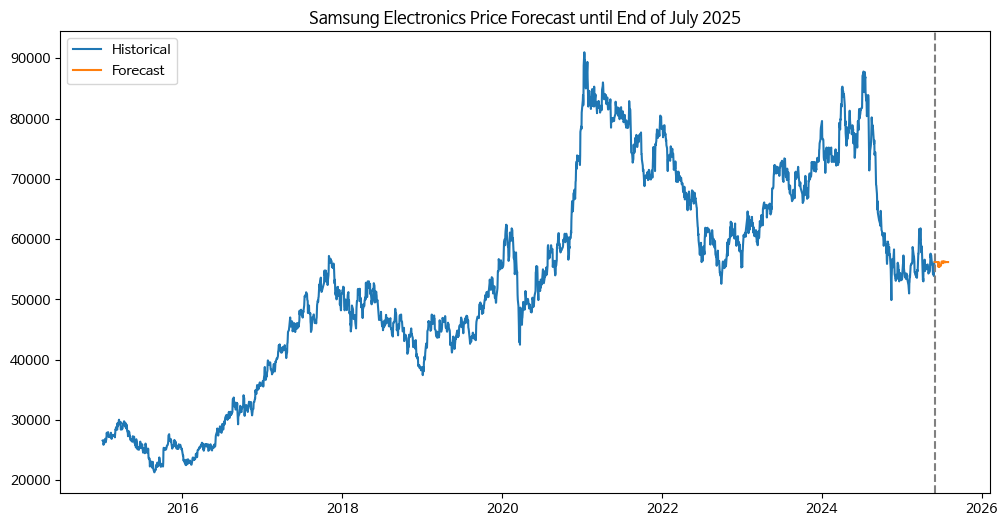

In [12]:
import numpy as np
import pandas as pd
import sys
from pykrx import stock
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 설정
ticker = '005930'                 # 삼성전자의 KRX 티커 코드
start_date = '20150101'             # 데이터 수집 시작 (YYYYMMDD)
end_date = '20250601'               # 데이터 수집 종료
window_size = 20                    # GAF 변환에 사용할 창 크기
image_size = window_size            # image_size는 window_size 이하
forecast_end = '20250731'           # 예측 종료 날짜: 2025년 7월 31일 (YYYYMMDD)


def download_data_pykrx(ticker, start, end):
    """PyKrX를 이용해 KRX 주가(OHLCV) 데이터를 가져옵니다."""
    df = stock.get_market_ohlcv_by_date(start, end, ticker)
    if df.empty:
        print(f"PyKrX 데이터 없음: {ticker} {start}-{end}", file=sys.stderr)
        sys.exit(1)
    df.rename(columns={"종가": "Adj Close"}, inplace=True)
    return df

# 1. 데이터 로드 및 수익률 계산
df = download_data_pykrx(ticker, start_date, end_date)
df['Return'] = df['Adj Close'].pct_change().fillna(0)
returns = df['Return'].values
close_prices = df['Adj Close'].values

# 2. 과거 이미지 생성 함수 정의
def create_image(window):
    gaf = GramianAngularField(image_size=image_size, method='summation')
    img = gaf.fit_transform(window.reshape(1, -1))[0]
    return img.reshape(image_size, image_size, 1)

# 3. 데이터셋 준비
def prepare_dataset(returns):
    X, y = [], []
    for i in range(window_size, len(returns) - 1):
        X.append(create_image(returns[i-window_size:i]))
        y.append(returns[i+1])
    return np.array(X), np.array(y)

X, y = prepare_dataset(returns)
# 정규화
scaler = MinMaxScaler(feature_range=(0,1))
y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()

# 학습용: 과거 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)

# 4. CNN 모델 정의 및 학습
def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)), Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)), Dropout(0.25),
        Flatten(), Dense(128, activation='relu'), Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_cnn((image_size, image_size, 1))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[es])

# 5. 미래 예측
from datetime import timedelta
last_date = pd.to_datetime(df.index[-1])
end_date_forecast = pd.to_datetime(forecast_end, format='%Y%m%d')
forecast_days = (end_date_forecast - last_date).days

future_returns = []
window = returns[-window_size:].copy()
for _ in range(forecast_days):
    img = create_image(window)
    r_scaled = model.predict(img.reshape(1, image_size, image_size,1))[0,0]
    r = scaler.inverse_transform([[r_scaled]])[0,0]
    future_returns.append(r)
    window = np.roll(window, -1)
    window[-1] = r

# 미래 종가 계산
last_price = close_prices[-1]
future_prices = [last_price * (1 + r) for r in future_returns]
future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

# 6. 시각화 및 결과 출력
plt.figure(figsize=(12,6))
plt.plot(df.index, close_prices, label='Historical')
plt.plot(future_dates, future_prices, label='Forecast')
plt.axvline(df.index[-1], linestyle='--', color='gray')
plt.legend()
plt.title('Samsung Electronics Price Forecast until End of July 2025')
plt.show()
